In [14]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import time
import random
%matplotlib inline

In [15]:
# build the vocabulary of the given dataset.
words = open('names.txt', 'r').read().splitlines()
allWords = sorted(list(set(''.join(words))))
itos = {idx + 1 : alps for idx, alps in enumerate(allWords)}
itos[0] = '.'
stoi = { idx: alps for alps, idx in itos.items()}

In [16]:
# Building a dataset 

block_size = 3  # how many character we want to take in context to predict the next character. 

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for alpha in word + '.':
            ix = stoi[alpha]
            X.append(context)
            context = context[1:] + [ix]
            Y.append(ix)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

random.seed(1599)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr = build_dataset(words[:n1]) # 80% of the data
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% of the data
Xtes, Ytes = build_dataset(words[n2:])  # 10% of the data


In [17]:
n_emb = 10 # the dimensionality of the character embedding.
n_hidden = 200 # No of nurons in the hidden layer.
vocab_size = len(itos) # vacubulary size: total number of unique character

gen = torch.Generator().manual_seed(1599) # generator of a seed value for reproducibility.
C = torch.randn((vocab_size, n_emb),             generator=gen) # Fra
w1 = torch.randn((block_size * n_emb, n_hidden), generator=gen) * (5/3)/((n_emb * block_size) ** 0.5)
# b1 = torch.randn(n_hidden,                       generator=gen) * 0.01
w2 = torch.randn((n_hidden, vocab_size),         generator=gen) * 0.01
b2 = torch.randn(vocab_size,                     generator=gen) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

bnstd_running = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))

parameters = [C, w1, b2, w2, bn_gain, bn_bias]  # all the parameters in the mode.


sum(p.nelement() for p in parameters)
for par in parameters:
    par.requires_grad = True


In [18]:
max_steps = 200000
batch_size = 32
lossi =  []

for i in range(max_steps):

    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=gen)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embTrans = emb.view(emb.shape[0], -1)
    hpred = embTrans @ w1  # + b1 bias will not be need in BN: hidden layer pre-activation.
#     hpred = bn_gain * ((hpred - hpred.mean(0, keepdim=True)) / hpred.std(0, keepdim=True)) + bn_bias
    
    # bactch normalization.
    # ----------------------------------------------------------
    bnmeani = hpred.mean(0, keepdim=True)
    bnstdi =  hpred.std(0, keepdim=True)
    
    hpred = bn_gain * (hpred - bnmeani) / bnstdi + bn_bias 
    
    # keeping track of buffer batch mean/std without gradient tracking in a hacky way.
    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running + 0.01 * bnmeani
        bnstd_running = 0.99 * bnstd_running + 0.01 * bnstdi
    
    # ----------------------------------------------------------
    
    h = torch.tanh(hpred)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)  
    
    # backward pass
    # making sure all the grad are None.
    for param in parameters:
        param.grad = None

    # backpropogating through the neural nwtwork.
    loss.backward()
    
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay.

    # gradient decent with `lr` learning rate.
    for param in parameters:
        param.data += -lr * param.grad
    
    # printing the loss after every 10000 itteration
    if i % 10000 == 0:   
        print(f'{i:7d}/{max_steps:7d} ==> {loss.item():.4f}')

    lossi.append(loss.log10().item())
    break

      0/ 200000 ==> 3.2993


In [19]:
# caliberating the batch norm.
with torch.no_grad():
    
    # passing the traing set through.
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpred = embcat @ w1 
    
    # measure the mean/std on the entire training set.
    bn_mean = hpred.mean(0, keepdim=True)
    bn_std = hpred.std(0, keepdim=True)

In [20]:
@torch.no_grad()
def split_loss(split):
    
    x, y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xtes, Ytes),
    }[split]
    
    
    emb = C[x]
    embTrans = emb.view(emb.shape[0], -1)
    hpred = embTrans @ w1 
    hpred = bn_gain * ((hpred - bnmean_running) / bnstd_running) + bn_bias
    h = torch.tanh(hpred)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("dev")
split_loss("test")


# train 2.068439245223999
# dev 2.1093080043792725
# test 2.116943120956421

train 3.2558295726776123
dev 3.25284743309021
test 3.255464553833008


In [84]:


# Add semi-principal "kaiming init" insted of hacky init.
# we want to set the standard deviation of the weights of neural network to (gain / fan_mode ** 0.5);
# std = (5/3) / (# inputs in the NN ** 0.5) the gain for tanh = 5/3
# train 2.095449209213257
# dev 2.132533311843872
# test 2.1361732482910156

# Add Batch normalization:
# train 2.095449209213257
# dev 2.132533311843872
# test 2.1361732482910156


In [85]:
# sampling model;

gen = torch.Generator().manual_seed(1599)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=gen).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

tgyej.
hwloiiragifxghdeevnqav.
ulhmghfviipryvgqjpan.
pjxiibwkpixggpamkqhysqmuvubswfpzincsinvajquqkoencogudnwtdvzqmmzzeelgmzwrzuispxgdsiwmjdenwnjzkuwxygcezdefjvlpvsqpkaresrexcsvfboqbzvotqeaoincmzprgsrxrzisfuovajhzu.
aknxurvynfyhouhxlqdetrwpscl.
gupcffamqttoyqrtcsghaya.
xfslngfqzsoikdaq.
pjjpuxxvymglguzacmoayqqfasomouhihxetexi.
dtjkckeqtmovpblaohhyrqybujqjijq.
.
mrzbevvvdgfhvcyumlgtvdgigycvjkvabtqlmadwughhtfxufbncjqtvkuteaqeisr.
zuelwfucvhulftv.
tbgxediku.
facwi.
gilwxbregoskr.
l.
wwoqrn.
axnase.
jk.
mdmutqxmvoipvjdjcbqxhmrctjlutltawbvchvlxlwf.


In [86]:

# when initialize the NN: normalize the weigths by square root of fan-n; (# of inputs ** 0.5)
# x = torch.randn(1000, 10)
# w = torch.randn(10, 200) / 10 ** 0.5

# y = x @ w
# print(x.mean(), x.std())
# print(y.mean(), y.std())

# plt.figure(figsize=(20, 5))
# plt.subplot(121)
# plt.hist(x.view(-1).tolist(), 50, density=True);
# plt.subplot(122)
# plt.hist(y.view(-1).tolist(), 50, density=True);
# plt.hist(h.view(-1).tolist(), 50);
# plt.hist(hpred.view(-1).tolist(), 50);
# plt.figure(figsize=(14, 10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [99]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn((fan_in, fan_out), generator=gen) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out =  x @ self.weights 
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([self.bias] if self.bias is not None else [])
        
class BatchNormal:
    
    def __init__(self, dim, eps=1e-5, momentum=0.5 ):
        self.dim = dim
        self.aps = eps
        self.momentum = momentum
        self.training = True
        # parameter with backgroup.
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer (train with running 'mommentum update')
        self.running_mean = torch.ones(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forword pass.
        if self.training:
            # calculate batch mean and variance.
            xgamma = x.mean(0, keepdim=True)
            xvar = x.std(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize the unit variance 
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.bias
        
        # update the buffer.
        
        if self.training:
            if torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma + self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []
    

n_embd = 10 # dimentionality of the embedding words feature
n_hidden = 100 # of hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=gen)


layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

# making the initialization of the nn fan-m
with torch.no_grad():
    # last layer: make less confidence.
    layers[-1].weights *= 0.1
    # for other layer apply again.
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weights *= 5/3
            
parameters = [C] + [param for layer in layers for param in layer.parameters()]
print(sum(p.nelement() for p in parameters))

# making gradeint decent possible
for param in parameters:
    param.requires_grad = True

46497


In [100]:
max_steps = 250000
batch_size = 32
lossIdx = []
ud = []

for itter in range(max_steps):
    batch = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=gen)
    Xb, Yb = Xtr[batch], Ytr[batch]
    embd = C[Xb]
    x = embd.view(embd.shape[0], -1)
    
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if itter < 200000 else 0.01
    
    for param in parameters:
        param.data += -lr * param.grad 
        
    if itter % 50000 == 0:
        print(f"{itter} / {max_steps}: {loss}")
        
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
        
        
    lossi.append(loss.log10().item())
    if itter >= 1000:
        break
    

0 / 250000: 3.3304028511047363


layer 1 (Tanh): mean +0.01. std 0.79, saturated: 25.44%
layer 3 (Tanh): mean +0.03. std 0.72, saturated: 13.25%
layer 5 (Tanh): mean -0.01. std 0.72, saturated: 11.00%
layer 7 (Tanh): mean +0.03. std 0.72, saturated: 11.28%
layer 9 (Tanh): mean +0.08. std 0.71, saturated: 11.34%


Text(0.5, 1.0, 'activation distribution')

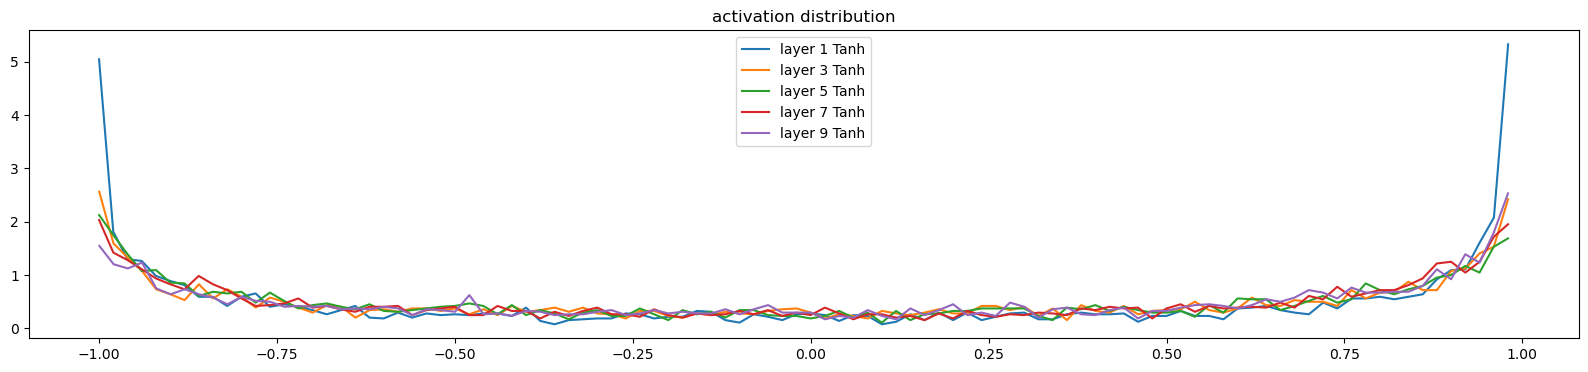

In [101]:

# Histogram for Forward pass.
plt.figure(figsize=(20, 4));
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer %d (%1s): mean %+.2f. std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100));
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("activation distribution")

layer 1 (Tanh): mean -0.000005. std 0.00, saturated: 0.00%
layer 3 (Tanh): mean +0.000021. std 0.00, saturated: 0.00%
layer 5 (Tanh): mean +0.000020. std 0.00, saturated: 0.00%
layer 7 (Tanh): mean +0.000014. std 0.00, saturated: 0.00%
layer 9 (Tanh): mean +0.000018. std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'gradient distribution')

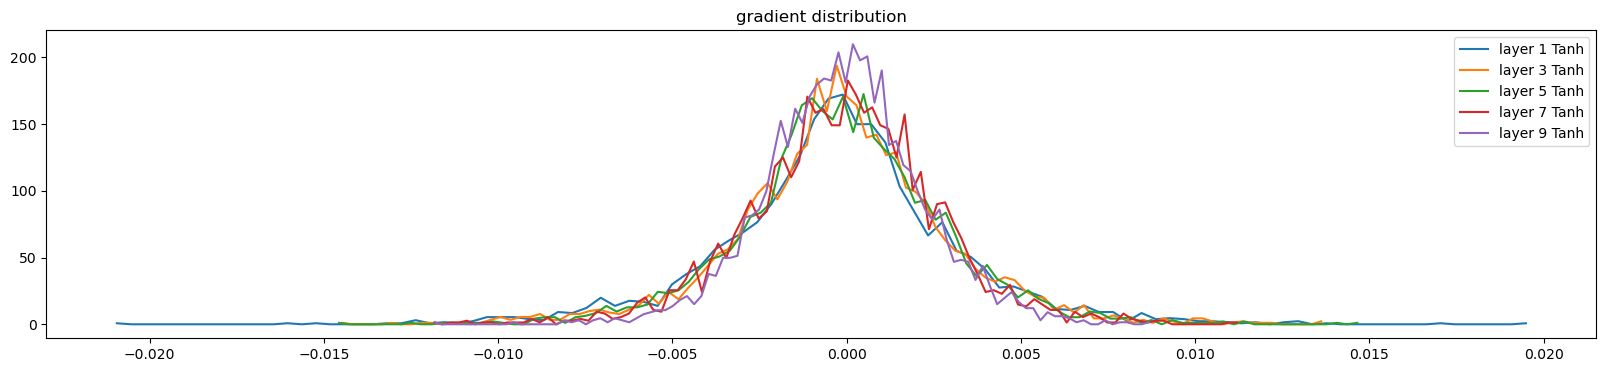

In [102]:

# Histogram for Forward pass.
plt.figure(figsize=(20, 4));
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer %d (%1s): mean %+f. std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100));
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {layer.__class__.__name__}")
plt.legend(legends)
plt.title("gradient distribution")

 weight (27, 10) | mean -0.000250. | std 1.235773e-02 | grad:data ratio 1.233703e-02
 weight (30, 100) | mean -0.000149. | std 1.084783e-02 | grad:data ratio 3.560673e-02
 weight (100, 100) | mean +0.000051. | std 8.144327e-03 | grad:data ratio 4.812130e-02
 weight (100, 100) | mean +0.000052. | std 6.777749e-03 | grad:data ratio 4.026718e-02
 weight (100, 100) | mean +0.000092. | std 6.272381e-03 | grad:data ratio 3.719845e-02
 weight (100, 100) | mean +0.000025. | std 5.218685e-03 | grad:data ratio 3.118315e-02
 weight (100, 27) | mean -0.000000. | std 2.186098e-02 | grad:data ratio 3.110228e-01


Text(0.5, 1.0, 'Weight Gradient Distribution')

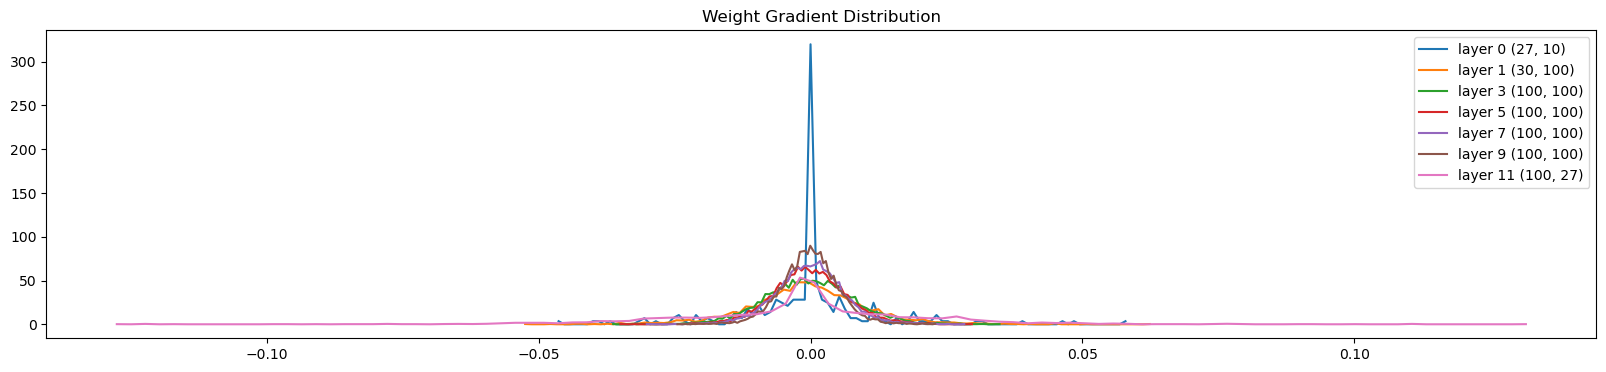

In [103]:

# Histogram for Forward pass.
plt.figure(figsize=(20, 4));
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        t = p.grad
        print(f" weight %5s | mean %+f. | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} {(tuple(p.shape))}")
plt.legend(legends)
plt.title("Weight Gradient Distribution")

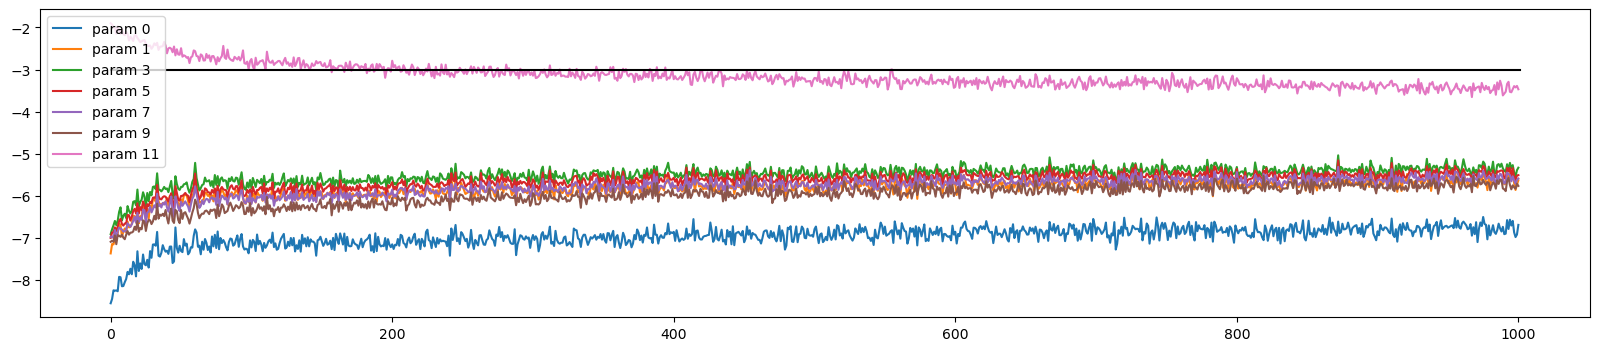

In [104]:

# Histogram for Forward pass.
plt.figure(figsize=(20, 4));
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)